### Syscoin Supply + Masternode Reward Simulations
* https://etherscan.io/chart/transactionfee

In [1]:
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize
import statsmodels.api as sm
from pymc3.gp.util import plot_gp_dist

In [2]:
# Jun 03 2019 (start)
# supply = 554103161

# June 28th, 2021
# supply 614730694

# Aug 23, 2021 
# supply 617746652

# July 12th, 2022 
# supply 650631036 + 100000000 - 13116676 = 737514361

### Simulate Prices

In [3]:
MASTERNODE_FEE = 100000
MASTERNODE_SUPPLY_SHARE = 0.34

def n_masternodes(supply_arr, share = MASTERNODE_SUPPLY_SHARE):
    return share*supply_arr/MASTERNODE_FEE

def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c

def gen_drift(N):    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    return mod.simulate([0.5, -5/3, 5/6, 4**2], N)

def scale_array(dat, out_range=(-1, 1)):
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))

def gen_prices(N, lwr_price, upr_price):
    
    x = range(1,N+1)
    y_trend = np.array([func_exp(e, 1, 0.002,0) for e in x])
    y_trend = scale_array(y_trend, (lwr_price, upr_price))
    drift = scale_array(np.abs(gen_drift(N)), (0, 1))
    sim = lwr_price + y_trend*drift
    
    return sim

In [4]:
utxo_supply = 650631037.54678924
nevm_supply = 100000000 - 13116676.320312181517900351
tot_supply = utxo_supply + nevm_supply # July 12th, 2022
tot_supply

737514361.2264771

### Ethereum Transaction Fees
* https://etherscan.io/chart/transactionfee
* last download: July 12th, 2022 

In [5]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [6]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [7]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [8]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [9]:
N = 365
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
STRT_YR = 2019
DEFLATION = 0.05
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45
NUM_DAILY_BLOCKS = 24*60

def gen_block_rewards(strt_date = STRT_DATE,
                      strt_supply = STRT_SUPPLY,
                      ini_blk_reward = INITIAL_BLK_REWARD,
                      n = N,
                      deflation = DEFLATION,
                      num_daily_blocks = NUM_DAILY_BLOCKS,
                      nevm_rewards = None,
                      pow_rewards = None):
    
    STRT_YR = datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S").year
    blk_rewards = [ini_blk_reward]
    dates = np.array([getDate(t, strt_date = strt_date) for t in range(0,n)])
    da = np.array([dates.flatten()[t].day for t in range(0,n)])
    mo = np.array([dates.flatten()[t].month for t in range(0,n)])
    yr = np.array([dates.flatten()[t].year for t in range(0,n)])

    rewards = np.repeat(0.0,n)
    rewards[0] = blk_rewards[0]

    for k in range(1, n):
        diff_yr = yr[k] - yr[k-1]
        rewards[k-1] = blk_rewards[len(blk_rewards)-1]
        
        if diff_yr == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
            blk_rewards.append(blk_reward - deflation*blk_reward)

    rewards[n-1] = rewards[n-2]  
    
    daily_rewards = rewards*num_daily_blocks       
            
    df = pd.DataFrame({'dates':dates.flatten(),
                       'yr':yr.flatten(),
                       'mo':mo.flatten(),
                       'da':da.flatten(),
                       'blk_reward':rewards,
                       'daily_rewards':daily_rewards,
                       'supply':strt_supply+np.cumsum(daily_rewards)})
    
    if (nevm_rewards != None): 
        df.insert(loc=5, column='nevm_rewards', value=nevm_rewards)

    if (pow_rewards != None): 
        df.insert(loc=6, column='pow_rewards', value=pow_rewards)  
        
    if (nevm_rewards != None) & (pow_rewards != None):
        rewards = rewards + np.repeat(nevm_rewards,n)
        daily_rewards = rewards*num_daily_blocks 
        df = df.assign(daily_rewards=daily_rewards)
          
    return df

### Supply Pre-NEVM

In [10]:
INDEX = 812
SUPPLY_AT_INDEX = 617746652 # Aug 23, 2021 
N_DAYS_TO_NEVM = 917

def objective_function(alpha):
    
    pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = alpha*38.5,
                           n = N_DAYS_TO_NEVM)
                  
    return abs(SUPPLY_AT_INDEX - pow_df['supply'].iloc[INDEX])

#### Estimate senority scaling factor

In [11]:
ALPHA_INIT = 1.4872300387520823
result = minimize(objective_function, ALPHA_INIT, method='SLSQP', options={'maxiter': 1000})
senority_scaling_factor = result.x[0]
senority_scaling_factor

1.4874179911283243

In [12]:
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = senority_scaling_factor*38.5

pre_nevm = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N_DAYS_TO_NEVM)

In [13]:
pre_nevm.tail(3)

,dates,yr,mo,da,blk_reward,daily_rewards,supply
914,2021-12-03,2021,12,3,51.682197,74422.364219,6.253377e+08
915,2021-12-04,2021,12,4,51.682197,74422.364219,6.254122e+08
916,2021-12-05,2021,12,5,51.682197,74422.364219,6.254866e+08


### Supply Post-NEVM

In [14]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 23.45)

nevm_lwr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 5.27)

In [15]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*pre_nevm['blk_reward'].iloc[-1]

nevm_med = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [16]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 46.9)

nevm_upr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [17]:
nevm_df = nevm_lwr.iloc[:, [0,1,2,3]]
nevm_df.insert(loc=4, column='blk_reward_lwr', value=nevm_lwr['blk_reward'].values)
nevm_df.insert(loc=5, column='nevm_rewards_lwr', value=nevm_lwr['nevm_rewards'].values)
nevm_df.insert(loc=6, column='pow_rewards_lwr', value=nevm_lwr['pow_rewards'].values)
nevm_df.insert(loc=7, column='daily_rewards_lwr', value=nevm_lwr['daily_rewards'].values)
nevm_df.insert(loc=8, column='supply_lwr', value=nevm_lwr['supply'].values)

nevm_df.insert(loc=9, column='blk_reward_upr', value=nevm_upr['blk_reward'].values)
nevm_df.insert(loc=10, column='nevm_rewards_upr', value=nevm_upr['nevm_rewards'].values)
nevm_df.insert(loc=11, column='pow_rewards_upr', value=nevm_upr['pow_rewards'].values)
nevm_df.insert(loc=12, column='daily_rewards_upr', value=nevm_upr['daily_rewards'].values)
nevm_df.insert(loc=13, column='supply_upr', value=nevm_upr['supply'].values)

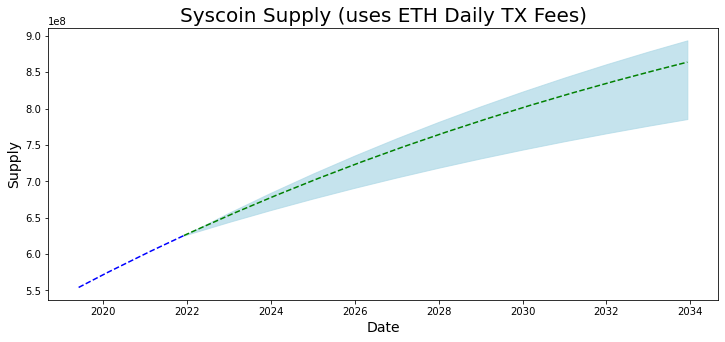

In [18]:
fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_df['dates'].values, nevm_df['supply_lwr'].values, nevm_df['supply_upr'].values, alpha=0.7, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
plt.ylabel("Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)
fig.savefig('../img/syscoin_daily_supply.png')

### NEVM Supply Predictions

In [19]:
import statsmodels.api as sm

N = 12*365

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2439,2439+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [20]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [21]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [22]:
dates = [getDate(t) for t in range(0,2439)]
dates_pred = [getDate(t) for t in range(2440,2440+N)]

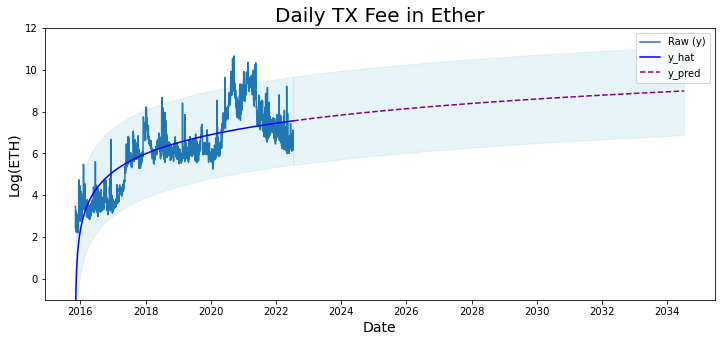

In [23]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2440,2440+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

plt.plot(dates_pred, y_pred, color='purple', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log(ETH)", fontsize=14)
plt.ylim(-1,12)
plt.legend();
fig.savefig('../img/eth_daily_tx_fee.png')

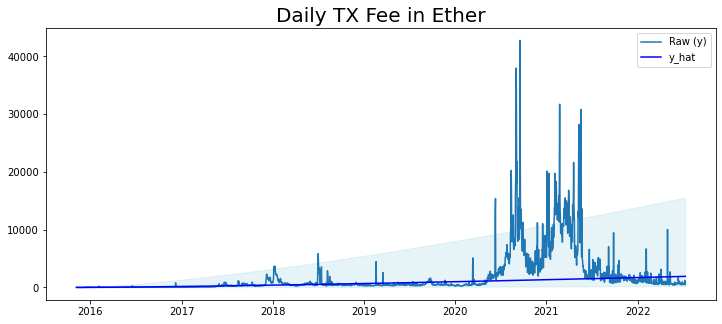

In [24]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

In [25]:
dates_ = np.append(dates, dates_pred[1:])
y_hat_ = np.append(y_hat, y_pred[1:])
y_hat_lwr_ = np.append(y_hat_lwr, y_pred_lwr[1:])
y_pred_upr_ = np.append(y_hat_upr, y_pred_upr[1:])

est_df = pd.DataFrame({'dates':dates_,
                        'pred':np.cumsum(np.exp(y_hat_)),
                        'pred_lwr':np.cumsum(np.exp(y_hat_lwr_)),
                        'pred_upr':np.cumsum(np.exp(y_pred_upr_))})

est_df = est_df.iloc[0:len(nevm_df)]

Text(0.5, 24.0, 'Date')

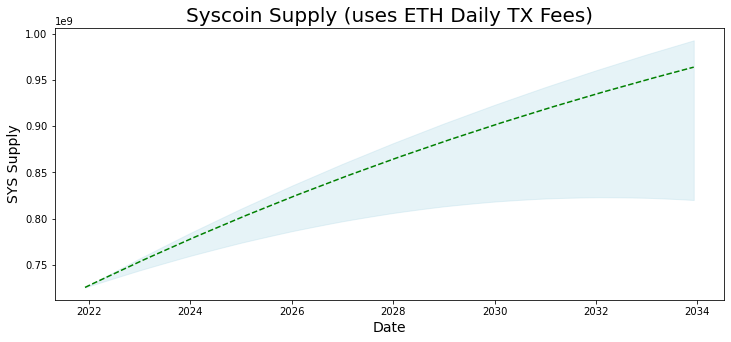

In [26]:
addition_supply = 100000000

coin_supply_upr = addition_supply + nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = addition_supply + nevm_df['supply_lwr'].values - est_df['pred_upr'].values


sys_dates = nevm_med['dates'].values
sys_supply =  addition_supply+nevm_med['supply'].values

fig = plt.figure(figsize=(12,5))
plt.plot(sys_dates, sys_supply, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

Text(0.5, 24.0, 'Date')

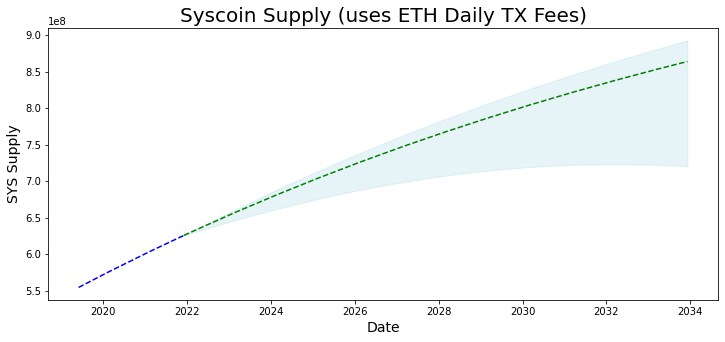

In [27]:
coin_supply_upr = nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = nevm_df['supply_lwr'].values - est_df['pred_upr'].values

fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

In [28]:
pred_df = pd.DataFrame({'dates': nevm_med['dates'].values,
                        'pred':addition_supply + nevm_med['supply'].values,
                        'pred_lwr':addition_supply + coin_supply_lwr,
                        'pred_upr':addition_supply + coin_supply_upr})

In [29]:
mo = pd.to_datetime(pred_df['dates'].values).month
da = pd.to_datetime(pred_df['dates'].values).day

indices = []
m = 0
for k in range(0,len(pred_df)):
    if((mo[k] == 1) & (da[k] == 1)): indices.append(k)
    
pred_df.iloc[indices]

,dates,pred,pred_lwr,pred_upr
26,2022-01-01,7.274923e+08,7.268338e+08,7.277442e+08
391,2023-01-01,7.532947e+08,7.439698e+08,7.567852e+08
756,2024-01-01,7.778070e+08,7.596725e+08,7.843653e+08
1122,2025-01-01,8.011575e+08,7.738445e+08,8.106263e+08
1487,2026-01-01,8.232798e+08,7.863225e+08,8.354917e+08
1852,2027-01-01,8.442961e+08,7.970827e+08,8.590972e+08
2217,2028-01-01,8.642615e+08,8.060737e+08,8.815038e+08
2583,2029-01-01,8.832806e+08,8.132267e+08,9.028284e+08
2948,2030-01-01,9.012994e+08,8.184266e+08,9.230100e+08
3313,2031-01-01,9.184172e+08,8.217214e+08,9.421585e+08


### Price simulations

In [30]:
N = 5*365 + 27
LWR_SYS_PRICE = 0.25
UPR_SYS_PRICE = 25

price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
for k in range(1,50):
    sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
    price_sim = np.hstack((price_sim,sim))

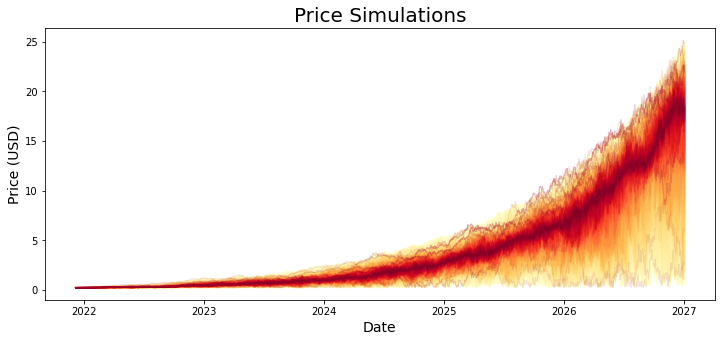

In [31]:
start = datetime.datetime(2021, 12, 6, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, price_sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Price Simulations", fontsize=20)
fig.savefig('../img/price_simulations.png')

### Rewards simulations

In [32]:
nevm_med[0:30]

,dates,yr,mo,da,blk_reward,nevm_rewards,pow_rewards,daily_rewards,supply
0,2021-12-06,2021,12,6,129.205493,10.55,10.55,80499.164219,6.255610e+08
1,2021-12-07,2021,12,7,129.205493,10.55,10.55,80499.164219,6.256354e+08
2,2021-12-08,2021,12,8,129.205493,10.55,10.55,80499.164219,6.257098e+08
3,2021-12-09,2021,12,9,129.205493,10.55,10.55,80499.164219,6.257843e+08
4,2021-12-10,2021,12,10,129.205493,10.55,10.55,80499.164219,6.258587e+08
5,2021-12-11,2021,12,11,129.205493,10.55,10.55,80499.164219,6.259331e+08
6,2021-12-12,2021,12,12,129.205493,10.55,10.55,80499.164219,6.260075e+08
7,2021-12-13,2021,12,13,129.205493,10.55,10.55,80499.164219,6.260820e+08
8,2021-12-14,2021,12,14,129.205493,10.55,10.55,80499.164219,6.261564e+08
9,2021-12-15,2021,12,15,129.205493,10.55,10.55,80499.164219,6.262308e+08


In [33]:
nevm_df_final = copy.copy(nevm_df)
nevm_df_final = nevm_df_final.assign(supply=100000000+nevm_med['supply'].values)
nevm_df_final = nevm_df_final.assign(supply_lwr=100000000+coin_supply_lwr)
nevm_df_final = nevm_df_final.assign(supply_upr=100000000+coin_supply_upr)
nevm_df_final = nevm_df_final.assign(m_nodes = n_masternodes(100000000+nevm_med['supply'].values, share = MASTERNODE_SUPPLY_SHARE))
nevm_df_final = nevm_df_final.assign(daily_rewards_mu = nevm_med['daily_rewards'].values)
nevm_df_final = nevm_df_final.assign(blk_reward=nevm_med['blk_reward'].values)
nevm_df_final = nevm_df_final.assign(nevm_rewards=nevm_med['nevm_rewards'].values)
nevm_df_final = nevm_df_final.assign(pow_rewards=nevm_med['pow_rewards'].values)
nevm_df_final = nevm_df_final.assign(daily_rewards=nevm_med['daily_rewards'].values)
nevm_df_final = nevm_df_final[nevm_df_final['yr'].values > 2022]
nevm_df_final = nevm_df_final[nevm_df_final['yr'].values < 2028]

In [34]:
pred_dates = nevm_df_final['dates'].values
daily_rewards_lwr = nevm_df_final['daily_rewards_lwr'].values
daily_rewards_mu = nevm_df_final['daily_rewards_mu'].values
daily_rewards_upr = nevm_df_final['daily_rewards_lwr'].values

In [35]:
N = len(nevm_df_final)
price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
prices_sim = price_sim.reshape(-1,1)
reward_sim = price_sim*daily_rewards_mu[0:N]
reward_sim = reward_sim.reshape(-1,1)
for k in range(1,50):
    price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
    prices_sim = np.hstack((prices_sim,price_sim.reshape(-1,1)))
    sim_med = price_sim*daily_rewards_mu[0:N]  
    sim_med = sim_med.reshape(-1,1)
    reward_sim = np.hstack((reward_sim,sim_med))

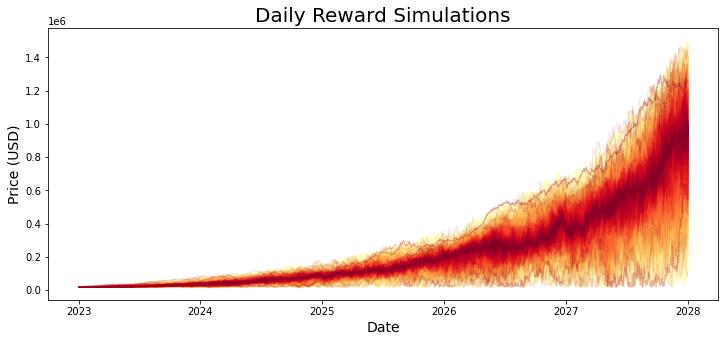

In [36]:
start = datetime.datetime(2023, 1, 1, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, reward_sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Reward Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

In [37]:
reward_mu = [np.quantile(reward_sim[0], 0.5)]
reward_lwr = [np.quantile(reward_sim[0], 0.05)]
reward_upr = [np.quantile(reward_sim[0], 0.95)]

price_mu = [np.quantile(prices_sim[0], 0.5)]
price_lwr = [np.quantile(prices_sim[0], 0.05)]
price_upr = [np.quantile(prices_sim[0], 0.95)]

for day in range(1,N):
    reward_mu.append(np.quantile(reward_sim[day], 0.5))
    reward_lwr.append(np.quantile(reward_sim[day], 0.05))
    reward_upr.append(np.quantile(reward_sim[day], 0.95))
    
    price_mu.append(np.quantile(prices_sim[day], 0.5))
    price_lwr.append(np.quantile(prices_sim[day], 0.05))
    price_upr.append(np.quantile(prices_sim[day], 0.95))    

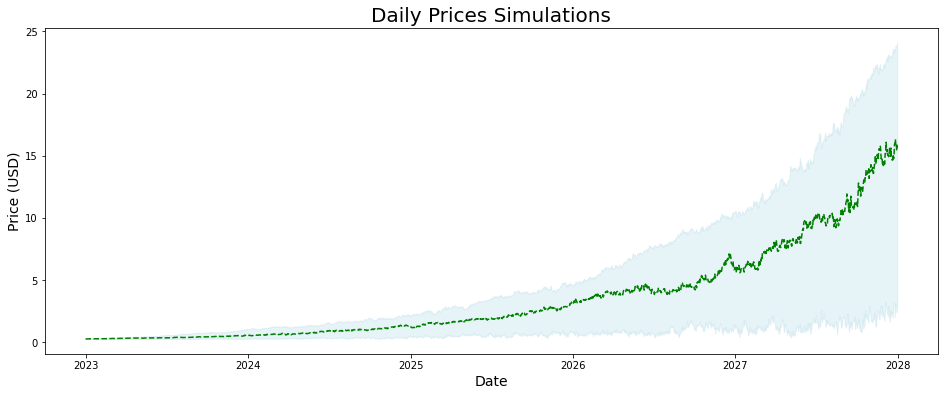

In [38]:
fig = plt.figure(figsize=(16, 6))
ax = fig.gca()
plt.plot(date_times, price_mu, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(date_times, price_lwr, price_upr, alpha=0.3, color='lightblue')
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Prices Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

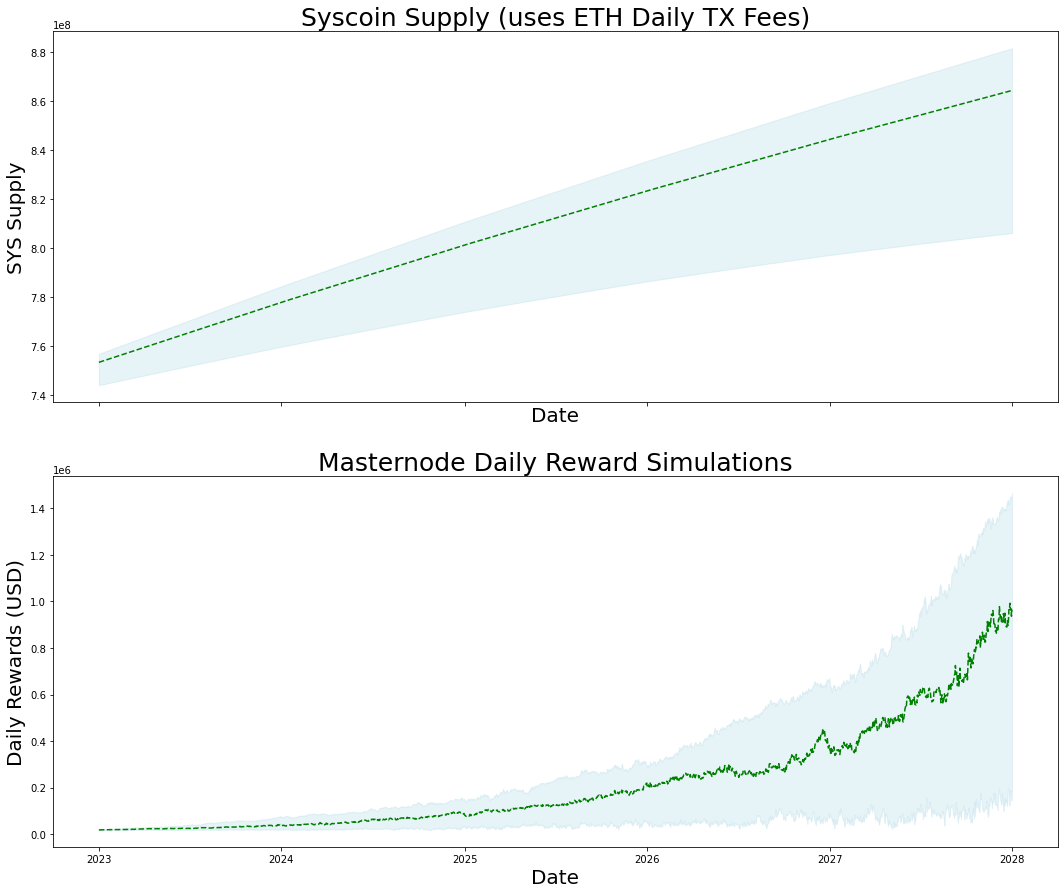

In [39]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

sys_supply =  nevm_df_final['supply'].values 
sys_supply_lwr =  nevm_df_final['supply_lwr'].values 
sys_supply_upr =  nevm_df_final['supply_upr'].values 

s_ax.plot(date_times, sys_supply, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, sys_supply_lwr, sys_supply_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=25)
s_ax.set_ylabel("SYS Supply", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

r_ax.fill_between(date_times, reward_lwr, reward_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, reward_mu, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Daily Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Daily Reward Simulations", fontsize=25)
fig.savefig('../img/supply_mn_reward_simulations.png')


In [40]:
dat = {
    'date' : date_times,
    'year' : [date_times[k].year for k in range(N)],
    'month' : [date_times[k].month for k in range(N)],    
    'nsys' : sys_supply,
    'nsys_lwr' : sys_supply_lwr,
    'nsys_upr' : sys_supply_upr,
    'price' : price_mu,
    'price_lwr' : price_lwr,
    'price_upr' : price_upr,    
    'reward' : reward_mu,
    'reward_lwr' : reward_lwr,
    'reward_upr' : reward_upr,
    'num_m_nodes' : nevm_df_final['m_nodes'].values[0:N]
}
  
proj = pd.DataFrame(dat)
proj = proj.set_index('date')

In [41]:
proj_system_aggr = pd.DataFrame(proj.groupby([(proj.index.year), (proj.index.month)])['nsys'].median())
proj_system_aggr['nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_lwr'].median().values
proj_system_aggr['nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_upr'].median().values
proj_system_aggr['reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward'].sum().values
proj_system_aggr['reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_lwr'].sum().values
proj_system_aggr['reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_upr'].sum().values
proj_system_aggr['price'] = proj.groupby([(proj.index.year), (proj.index.month)])['price'].median().values
proj_system_aggr['price_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_lwr'].median().values
proj_system_aggr['price_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_upr'].median().values
proj_system_aggr['num_m_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['num_m_nodes'].max().values

In [42]:
proj_system_aggr.index.names = ['year','month']
proj_system_aggr.reset_index(level=['year', 'month'], inplace=True)
proj_system_aggr.to_csv('../img/proj_system_aggr.csv')

### Investment nodes

In [43]:
N_INVEST_MASTERNODES = 400

nevm_df_invest = copy.copy(nevm_df_final[['dates','yr','mo','da']])
nevm_df_invest = nevm_df_invest.assign(blk_invest=nevm_df_final['blk_reward_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(pow_invest_lwr=nevm_df_final['pow_rewards_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(pow_invest_upr=nevm_df_final['pow_rewards_upr'].values)
nevm_df_invest = nevm_df_invest.assign(nevm_invest_lwr=nevm_df_final['nevm_rewards_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(nevm_invest_upr=nevm_df_final['nevm_rewards_upr'].values)
nevm_df_invest = nevm_df_invest.assign(num_m_nodes = nevm_df_final['m_nodes'].values + 400)
nevm_df_invest = nevm_df_invest.assign(blk_share = 1/nevm_df_invest['num_m_nodes'].values)

#### Adjust for senority

In [44]:
seg = nevm_df_invest['yr'] > 2023
nevm_df_invest.loc[seg, 'blk_invest'] = 1.35*nevm_df_invest.loc[seg, 'blk_invest']

seg = np.array(range(0,len(nevm_df_invest))) > 911
nevm_df_invest.loc[seg, 'blk_invest'] = 2*nevm_df_invest.loc[seg, 'blk_invest']

nevm_df_invest.head(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share
391,2023-01-01,2023,1,1,78.348281,5.27,10.55,10.55,10.55,2961.201912,0.000338
392,2023-01-02,2023,1,2,78.348281,5.27,10.55,10.55,10.55,2961.430277,0.000338
393,2023-01-03,2023,1,3,78.348281,5.27,10.55,10.55,10.55,2961.658642,0.000338
394,2023-01-04,2023,1,4,78.348281,5.27,10.55,10.55,10.55,2961.887007,0.000338
395,2023-01-05,2023,1,5,78.348281,5.27,10.55,10.55,10.55,2962.115372,0.000338


In [45]:
nevm_df_invest.tail(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share
2212,2027-12-27,2027,12,27,172.300945,5.27,10.55,10.55,10.55,3337.568284,0.0003
2213,2027-12-28,2027,12,28,172.300945,5.27,10.55,10.55,10.55,3337.754289,0.0003
2214,2027-12-29,2027,12,29,172.300945,5.27,10.55,10.55,10.55,3337.940294,0.0003
2215,2027-12-30,2027,12,30,172.300945,5.27,10.55,10.55,10.55,3338.126298,0.0003
2216,2027-12-31,2027,12,31,172.300945,5.27,10.55,10.55,10.55,3338.312303,0.0003


In [46]:
invest_supply_lwr = nevm_df_invest['blk_invest'].values + nevm_df_invest['pow_invest_lwr'].values + nevm_df_invest['nevm_invest_lwr'].values
invest_supply_upr = nevm_df_invest['blk_invest'].values + nevm_df_invest['pow_invest_upr'].values + nevm_df_invest['nevm_invest_upr'].values
invest_supply_lwr = NUM_DAILY_BLOCKS*N_INVEST_MASTERNODES*invest_supply_lwr*nevm_df_invest['blk_share'].values
invest_supply_upr = NUM_DAILY_BLOCKS*N_INVEST_MASTERNODES*invest_supply_upr*nevm_df_invest['blk_share'].values
invest_supply_med = (invest_supply_lwr + invest_supply_upr)/2

nevm_df_invest = nevm_df_invest.assign(invest_supply_med = invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(invest_supply_lwr = invest_supply_lwr)
nevm_df_invest = nevm_df_invest.assign(invest_supply_upr = invest_supply_upr)

nevm_df_invest.head(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share,invest_supply_med,invest_supply_lwr,invest_supply_upr
391,2023-01-01,2023,1,1,78.348281,5.27,10.55,10.55,10.55,2961.201912,0.000338,7532.288800,7326.880315,7737.697286
392,2023-01-02,2023,1,2,78.348281,5.27,10.55,10.55,10.55,2961.430277,0.000338,7531.707962,7326.315317,7737.100608
393,2023-01-03,2023,1,3,78.348281,5.27,10.55,10.55,10.55,2961.658642,0.000338,7531.127214,7325.750405,7736.504022
394,2023-01-04,2023,1,4,78.348281,5.27,10.55,10.55,10.55,2961.887007,0.000338,7530.546555,7325.185581,7735.907529
395,2023-01-05,2023,1,5,78.348281,5.27,10.55,10.55,10.55,2962.115372,0.000338,7529.965986,7324.620844,7735.311127


In [47]:
nevm_df_invest = nevm_df_invest.assign(price = price_mu)
nevm_df_invest = nevm_df_invest.assign(price_lwr = price_lwr)
nevm_df_invest = nevm_df_invest.assign(price_upr = price_upr)

nevm_df_invest = nevm_df_invest.assign(rewards = price_mu*invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(rewards_lwr = price_lwr*invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(rewards_upr = price_upr*invest_supply_med)

In [48]:
dat = {
    'date' : nevm_df_invest['dates'].values,
    'year' : nevm_df_invest['yr'].values,
    'month' : nevm_df_invest['mo'].values,    
    'nsys' : nevm_df_invest['invest_supply_med'].values,
    'nsys_lwr' : nevm_df_invest['invest_supply_lwr'].values,
    'nsys_upr' : nevm_df_invest['invest_supply_upr'].values,
    'price' : nevm_df_invest['price'].values,
    'price_lwr' : nevm_df_invest['price_lwr'].values,
    'price_upr' : nevm_df_invest['price_upr'].values,    
    'reward' : nevm_df_invest['rewards'].values,
    'reward_lwr' : nevm_df_invest['rewards_lwr'].values,
    'reward_upr' : nevm_df_invest['rewards_upr'].values,
    'tot_nodes' : nevm_df_invest['num_m_nodes'].values,
    'investment_nodes' : N_INVEST_MASTERNODES
}
  
proj = pd.DataFrame(dat)
proj = proj.set_index('date')

In [49]:
proj_invest_aggr = pd.DataFrame(proj.groupby([(proj.index.year), (proj.index.month)])['nsys'].median())
proj_invest_aggr['nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_lwr'].median().values
proj_invest_aggr['nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_upr'].median().values
proj_invest_aggr['reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward'].sum().values
proj_invest_aggr['reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_lwr'].sum().values
proj_invest_aggr['reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_upr'].sum().values
proj_invest_aggr['price'] = proj.groupby([(proj.index.year), (proj.index.month)])['price'].median().values
proj_invest_aggr['price_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_lwr'].median().values
proj_invest_aggr['price_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_upr'].median().values
proj_invest_aggr['num_m_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['num_m_nodes'].max().values

KeyError: 'Column not found: num_m_nodes'

In [ ]:
proj_invest_aggr.index.names = ['year','month']
proj_invest_aggr.reset_index(level=['year', 'month'], inplace=True)
proj_invest_aggr.to_csv('../img/proj_invest_aggr.csv')